In [2]:
import experiments
%load_ext autoreload
%autoreload 2

import analysis
import plots
import runner
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)
sns.set_style("white")
sns.set_style("ticks")

from matplotlib import mlab

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exploration of variations of noise input 

In [2]:
params = dict()
params['runtime'] = 400
params['min_dt'] = 0.05
params['ou_stationary'] = True

### Weak Correlation - Default Configuration

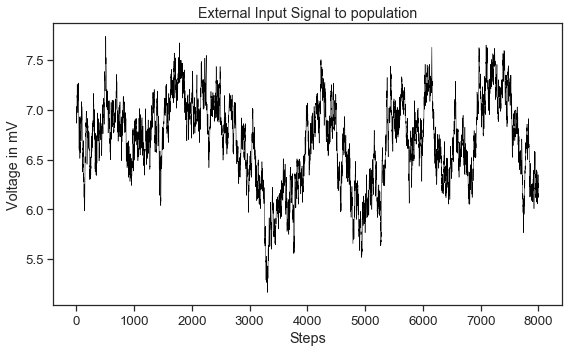

In [12]:
params['ou_mu'] = {
    'ou_X0': 0.,
    'ou_mean': 5.0,
    'ou_sigma': .5,
    'ou_tau': 50.
}

# noise params for sigma
params['ou_sigma'] = {
    'ou_X0': 0.,
    'ou_mean': 2.0,
    'ou_sigma': 0.2,
    'ou_tau': 1.
}

fig, ax = plots.ou_noise_by_params(params)
fig.savefig("plots/noise_experiment/weak_noise_correlation")

### Medium Correlation - Default Configuration

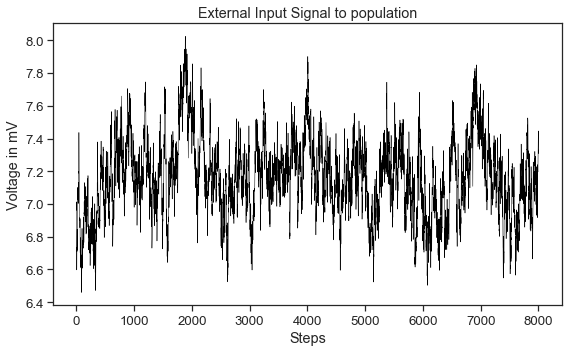

In [13]:
params['ou_mu'] = {
    'ou_X0': 0.,
    'ou_mean': 5.0,
    'ou_sigma': .5,
    'ou_tau': 500.
}

# noise params for sigma
params['ou_sigma'] = {
    'ou_X0': 0.,
    'ou_mean': 2.0,
    'ou_sigma': 0.2,
    'ou_tau': 1.
}

fig, ax = plots.ou_noise_by_params(params)
fig.savefig("plots/noise_experiment/medium_noise_correlation")

### Very Strong Correlation over Time

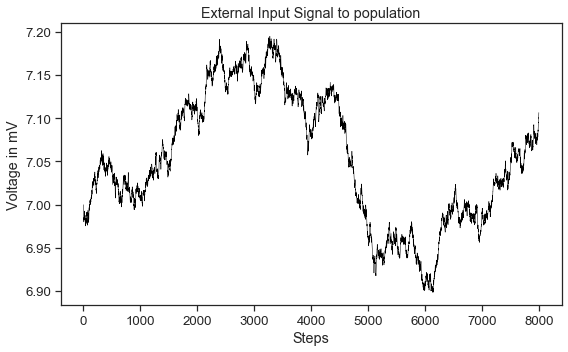

In [14]:
params['ou_mu'] = {
    'ou_X0': 0.,
    'ou_mean': 5.0,
    'ou_sigma': .5,
    'ou_tau': 5000.
}

params['ou_sigma'] = {
    'ou_X0': 0.,
    'ou_mean': 2.0,
    'ou_sigma': 0.2,
    'ou_tau': 10000.
}

fig, ax = plots.ou_noise_by_params(params)
fig.savefig("plots/noise_experiment/strong_noise_correlation")

In [6]:
results = runner.run("strong_correlation", modified_params=params)

building synapses...
build synapses time: 0.5983309745788574s
------------------ running network!
runtime: 45.4


INFO       width adjusted from 10. ms to 10.05 ms [brian2.monitors.ratemonitor.adjusted_width]


[Errno 17] File exists: 'plots/strong_correlation'
Generate PSD plot ...
Generate PSD plot ...


ValueError: x and y must have same first dimension, but have shapes (8000,) and (400,)

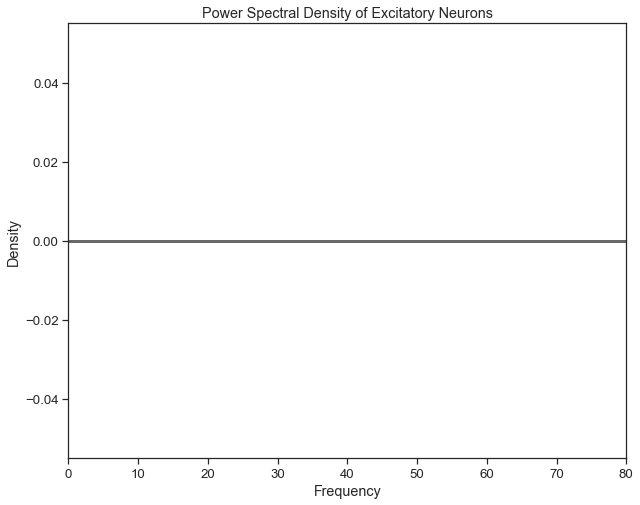

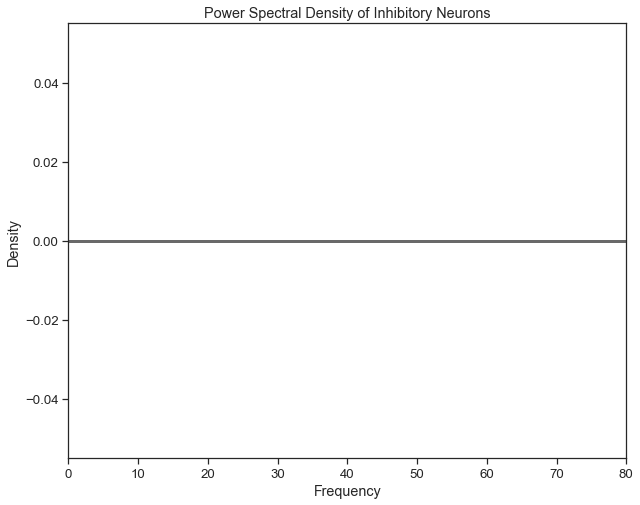

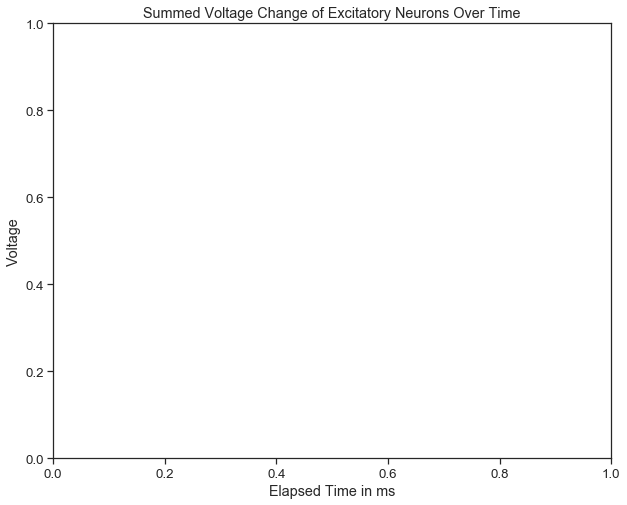

In [7]:
analysis.analyze_model(results, 'strong_correlation')

### Gaussian white noise (no correlation $\tau$ = 1)

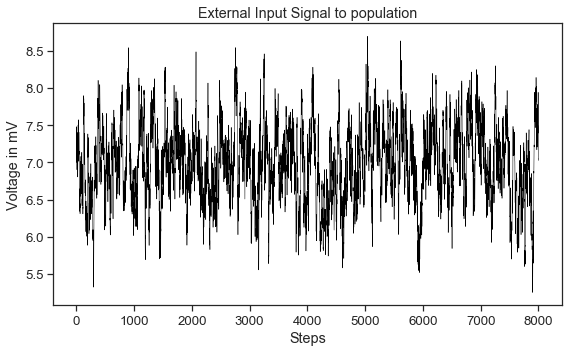

In [16]:
params['ou_mu'] = {
    'ou_X0': 0.,
    'ou_mean': 5.0,
    'ou_sigma': .5,
    'ou_tau': 1.
}

params['ou_sigma'] = {
    'ou_X0': 0.,
    'ou_mean': 2.0,
    'ou_sigma': 0.2,
    'ou_tau': 1.
}

fig, ax = plots.ou_noise_by_params(params)
fig.savefig("plots/noise_experiment/gaussian_white_noise")


In [ ]:
params['ou_mu'] = {
    'ou_X0': 0.,
    'ou_mean': 2.0,
    'ou_sigma': .5,
    'ou_tau': 1.
}

params['ou_sigma'] = {
    'ou_X0': 0.,
    'ou_mean': 0.0,
    'ou_sigma': 0.2,
    'ou_tau': 1.
}

plots.ou_noise_by_params(params)

In [ ]:
results = runner.run("low_strength", modified_params=params)

In [ ]:
analysis.analyze_model(results, 'low_strength')

## Effect of Mean on the Frequency

Parameter range: $0.5$ steps starting from $0$ and stopping at $4.5$.

The mean or strength of the noise is positively correlated with the dominant frequency of the network.
I.e. we see for each $0.5$ increase in the mean a rise in the frequency band.

Explanation: this result is not surprising as an increase in the mean leads to higher membrane voltage in the single neurons.
This results in faster crossing of the membrane threshold and stronger drive in the network.

TODO: verify explanations 

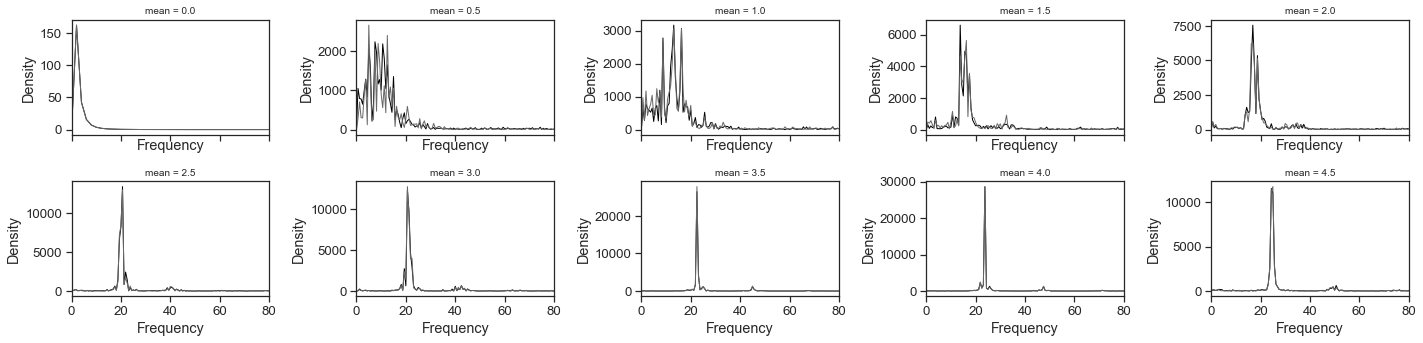

In [4]:
models = analysis.load([str(el) for el in np.arange(0, 5, 0.5)])
fig, axs = plots.all_psd(models=models, n_cols=2, n_rows=5)
fig.savefig("plots/noise_experiment/psd_freqs")

In [ ]:
noise_exp = experiments.NoiseExperiment()
noise_exp.run()

In [5]:
with open("models/noise/5-1-11.pkl", 'rb') as f:
    model = pickle.load(f) 

In [6]:
lfp1, lfp2 = plots._calculate_local_field_potentials(model)

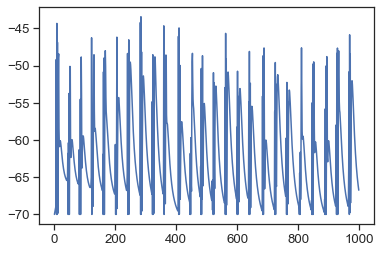

In [7]:
plt.plot(lfp1)

In [8]:
runtime_ = model["params"]["runtime"]
dt = 1.0
timepoints = int((runtime_ / dt) / 2)
fs = 1. / dt

psd, freqs = mlab.psd(lfp1, NFFT=int(timepoints), Fs=fs, noverlap=0, window=mlab.window_none)

psd[0] = 0.0
freqs = freqs * 1000

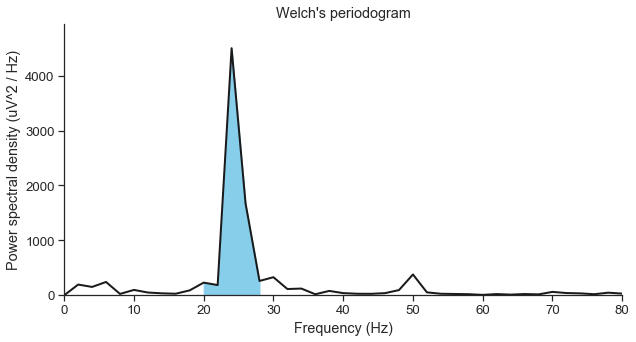

In [9]:
peak_freq = freqs[psd.argmax()]
low, high = (peak_freq - 5, peak_freq + 5)

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(10, 5))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 80])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

### Bandpower Heat Map 

We can see here that the higher that an increase in the mean leads to an increase in the gamma bandpower.

* With a mean around 0-1 mv the PING rhythm collapses and the gamma rhythm breaks apart.
* An increase in sigma / variance leads to a lower amplitude when the mean is fixed. 

Thus, a constant and strong external drive enforces the PING rhythm while variable and weak input deteriorates the gamma signal.

In [10]:
def create_plots(models, mean, sigma):
    model = [model for model in models if model["params"]["ou_mu"]["ou_sigma"] == sigma and model["params"]["ou_mu"]["ou_mean"] == mean][0]
    
    fig, ax = plots.raster(model, f"Raster Plot for mean = {mean} and sigma = {sigma}")
    fig.savefig(f"plots/noise_experiment/raster_{mean}_{sigma}")
    
    fig, ax = plots.psd(title="", model=model)
    fig.savefig(f"plots/noise_experiment/psd_{mean}_{sigma}")
    
    fig, ax = plots.summed_voltage(f"Summed Voltage for mean = {mean} and sigma = {sigma}", model)
    fig.savefig(f"plots/noise_experiment/summed_voltage_{mean}_{sigma}")

In [11]:
models = experiments.NoiseExperiment.load(lambda x: x["params"]["ou_mu"]["ou_tau"] == 1)

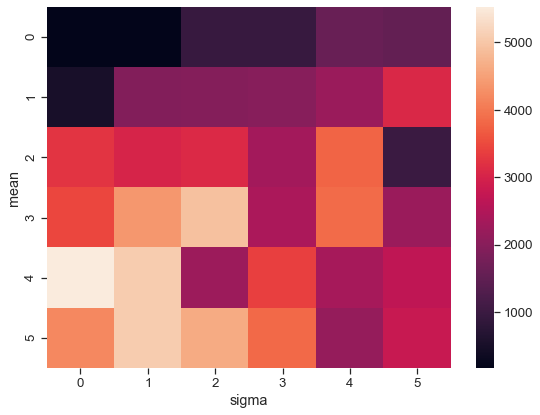

In [12]:
fig, ax, df = plots.heat_map(models, metric='bandpower')
plt.tight_layout()
fig.savefig("plots/noise_experiment/heatmap_mean_sigma_amplitude")

Below are plots of selected parameter configurations displayed.

Generate PSD plot ...
Generate PSD plot ...
Generate PSD plot ...
Generate PSD plot ...


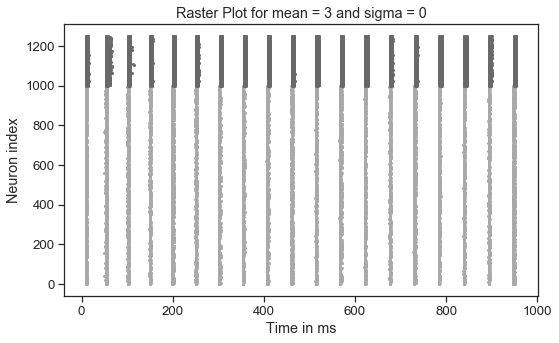

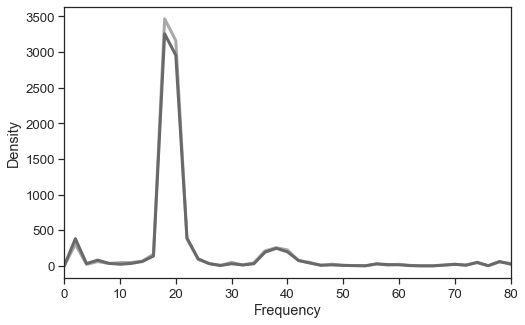

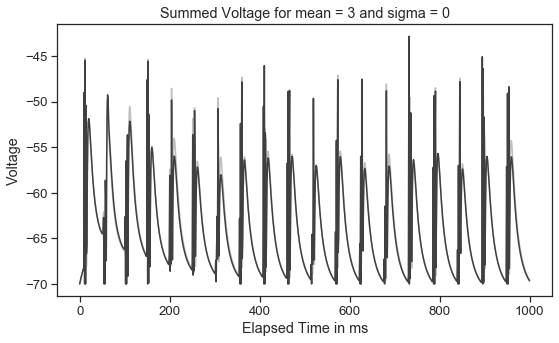

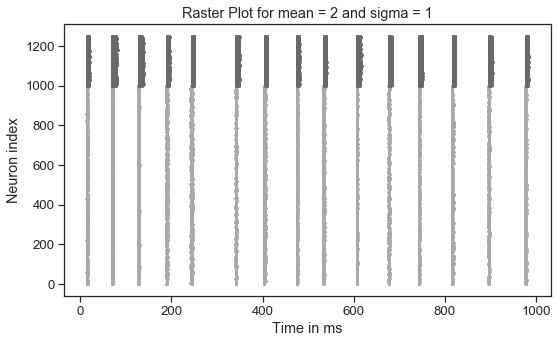

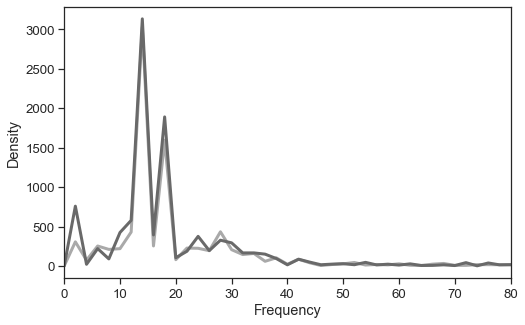

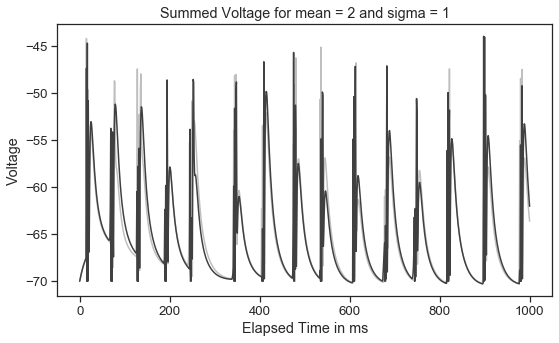

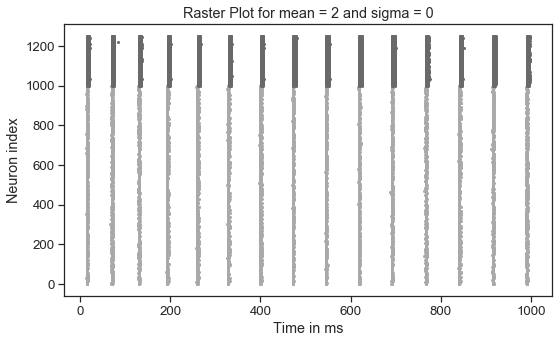

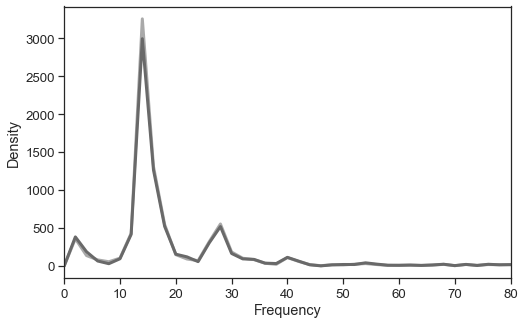

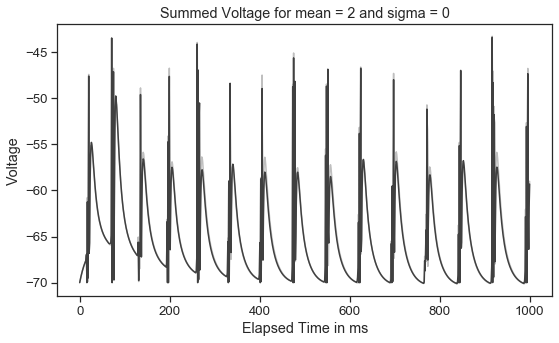

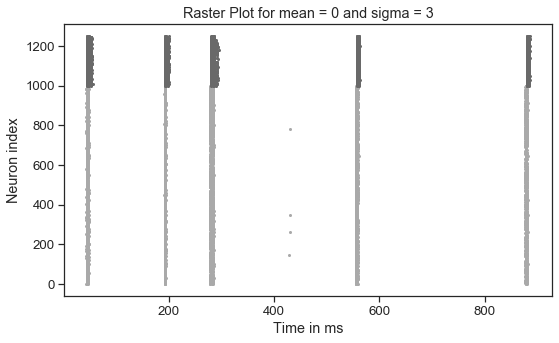

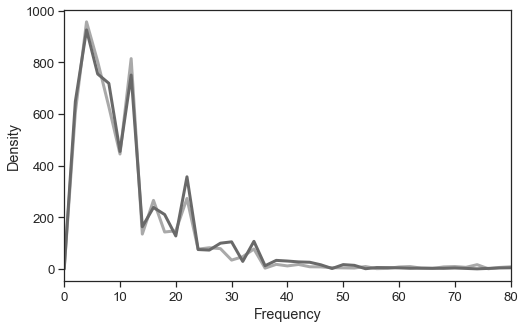

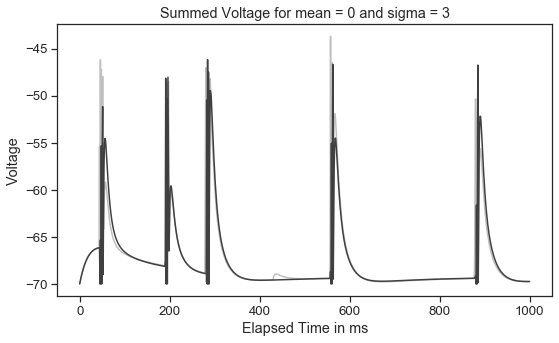

In [13]:
# really bad
mean, sigma = 3, 0
create_plots(models, mean, sigma)

# bad
mean, sigma = 2, 1
create_plots(models, mean, sigma)

# better
mean, sigma = 2, 0
create_plots(models, mean, sigma)

# best
mean, sigma = 0, 3
create_plots(models, mean, sigma)

### Frequency Heat Map

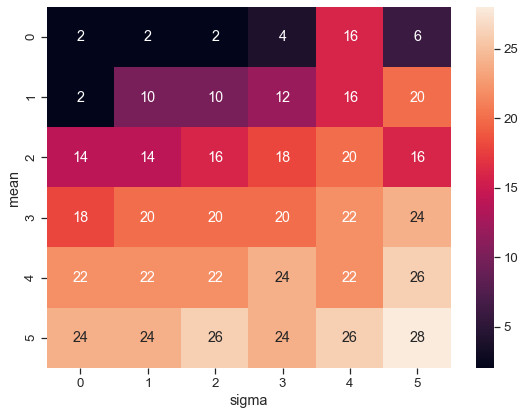

In [14]:
fig, ax, df = plots.heat_map(models, metric='freq', annot=True, fmt="d")
plt.tight_layout()

fig.savefig("plots/noise_experiment/heatmap_mean_sigma_freq")

### Impact of Correlation parameter $\tau$

Observations:
* No significant changes when over different correlation strengths if the variance stays low. 
* If variance is increased the PING rhythm gets weaker


In [15]:
models = experiments.NoiseExperiment.load(lambda x: x["params"]["ou_mu"]["ou_mean"] == 5)

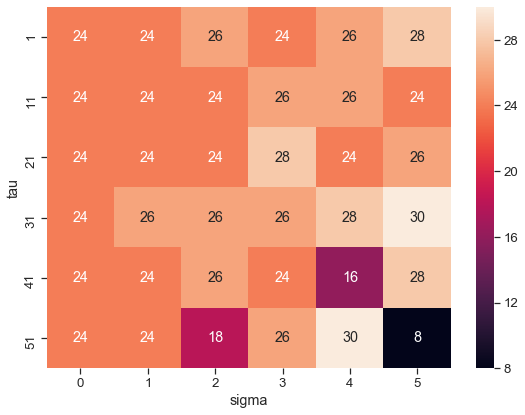

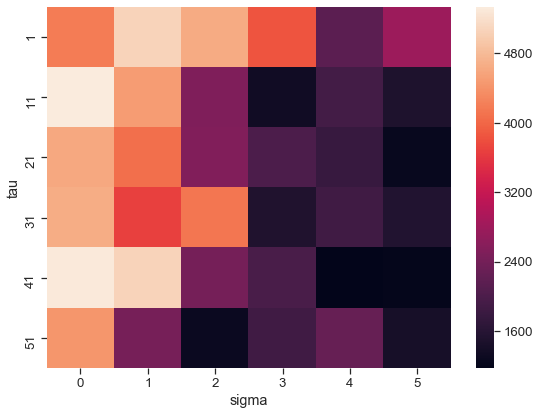

In [21]:
fig, ax, df = plots.heat_map(models, x='tau', metric='freq', annot=True, fmt="d")
plt.tight_layout()

fig.savefig("plots/noise_experiment/heatmap_correlation_1")

fig, ax, df = plots.heat_map(models, x='tau', metric='bandpower')
plt.tight_layout()

fig.savefig("plots/noise_experiment/heatmap_correlation_2")

In [ ]:
# clean up memory
models = None